In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import scipy.stats 

In [2]:
#Import Seasonal Data
data_nas = pd.read_csv('./mef-data/data_compiled_gapfilled_seasonal.csv')
data = data_nas.dropna().reset_index(drop = True)
data.head()

#Import Frost Data
#Bog Frost Depths
infile1  ="https://pasta.lternet.edu/package/data/eml/edi/572/1/fbbdd3f237bbde445450d897172ba556".strip() 
infile1  = infile1.replace("https://","http://")
                 
bogFrost =pd.read_csv(infile1, skiprows=1, sep=",",
                names=["peatland", "year", "frostDate", "depthToFrost", "frostThickness", "frostPercent"],
                parse_dates=['year', 'frostDate'],
                na_values={'frostThickness':['NA',],'frostPercent':['NA',],})
# Coerce the data into the types specified in the metadata  
bogFrost.peatland=bogFrost.peatland.astype('category') 
bogFrost=bogFrost.assign(year_datetime=pd.to_datetime(bogFrost.year,errors='coerce')) 
bogFrost=bogFrost.assign(frostDate_datetime=pd.to_datetime(bogFrost.frostDate,errors='coerce')) 
bogFrost.depthToFrost=pd.to_numeric(bogFrost.depthToFrost,errors='coerce',downcast='integer') 
bogFrost.frostThickness=pd.to_numeric(bogFrost.frostThickness,errors='coerce',downcast='integer') 
bogFrost.frostPercent=pd.to_numeric(bogFrost.frostPercent,errors='coerce',downcast='integer') 

#Upland Frost Depths
infile2  ="https://pasta.lternet.edu/package/data/eml/edi/571/3/cf159d50f0e80a99b14830103eec9297".strip() 
infile2  = infile2.replace("https://","http://")
                 
upFrost =pd.read_csv(infile2, skiprows=1, sep=",",
                names=["Watershed", "SnowcourseID", "Date", "Point", "FrostDEPTH"],
                parse_dates=['Date'] 
    )
# Coerce the data into the types specified in the metadata 
upFrost=upFrost.assign(Date_datetime=pd.to_datetime(upFrost.Date,errors='coerce'))  
upFrost.Point=upFrost.Point.astype('category') 
upFrost.FrostDEPTH=pd.to_numeric(upFrost.FrostDEPTH,errors='coerce',downcast='integer')    

#filter out the right watershed
bogFrost = bogFrost[bogFrost.peatland == 'S2'].reset_index(drop = True)
bogFrost['year'] = bogFrost.year_datetime.dt.year
bogFrostAnnual = bogFrost.groupby('year')[['depthToFrost', 'frostThickness', 'frostPercent']].mean().reset_index()

upFrost = upFrost[upFrost.Watershed == 'S2'].reset_index(drop = True)
upFrost['year'] = upFrost.Date_datetime.dt.year
upFrostAnnual = upFrost.groupby(['year', 'SnowcourseID'])['FrostDEPTH'].mean().reset_index()
upFrostAnnual = upFrostAnnual.pivot(index = 'year', columns = 'SnowcourseID', values = 'FrostDEPTH').reset_index()
upFrostAnnual['courseMean'] = upFrost.groupby(['year'])['FrostDEPTH'].mean().values
#Mean annual frost depth by snowcourse
bogFrostAnnual.head()

#Import raw streamflow data
infile1  ="https://pasta.lternet.edu/package/data/eml/edi/573/1/2aca4b900546e80ed7dd409ff1ad9787".strip() 
infile1  = infile1.replace("https://","http://")          
stream =pd.read_csv(infile1, storage_options = {'User-Agent':'EDI_CodeGen'}, skiprows = 1, sep=",", 
    names=["Peatland", "DateTime", "Stage_ft", "Q_cfs", "q_mmh", "q_interval"], 
    parse_dates=['DateTime'],
    na_values = 'NA')
# Coerce the data into the types specified in the metadata  
stream.Peatland=stream.Peatland.astype('category') 
# Since date conversions are tricky, the coerced dates will go into a new column with _datetime appended
# This new column is added to the dataframe but does not show up in automated summaries below. 
stream=stream.assign(DateTime_datetime=pd.to_datetime(stream.DateTime,errors='coerce')) 
stream.Stage_ft=pd.to_numeric(stream.Stage_ft,errors='coerce') 
stream.Q_cfs=pd.to_numeric(stream.Q_cfs,errors='coerce') 
stream.q_mmh=pd.to_numeric(stream.q_mmh,errors='coerce') 
stream.q_interval=pd.to_numeric(stream.q_interval,errors='coerce')               

#Import raw precipitation
infile1  ="https://pasta.lternet.edu/package/data/eml/edi/563/6/f3a58ff544a4ddd3475d265da61bf40e".strip() 
infile1  = infile1.replace("https://","http://")          
precip =pd.read_csv(infile1, storage_options={'User-Agent':'EDI_CodeGen'}, skiprows=1, sep=",",
                names=["DATE", "NADP_PCP", "South_PCP", "North_PCP", "NADP_Flag", "South_Flag", "North_Flag"], 
                parse_dates=['DATE'],
                na_values={'NA'})
# Coerce the data into the types specified in the metadata 
# Since date conversions are tricky, the coerced dates will go into a new column with _datetime appended
# This new column is added to the dataframe but does not show up in automated summaries below. 
precip=precip.assign(DATE_datetime=pd.to_datetime(precip.DATE,errors='coerce')) 
precip.NADP_PCP=pd.to_numeric(precip.NADP_PCP,errors='coerce') 
precip.South_PCP=pd.to_numeric(precip.South_PCP,errors='coerce') 
precip.North_PCP=pd.to_numeric(precip.North_PCP,errors='coerce') 
precip.NADP_Flag=pd.to_numeric(precip.NADP_Flag,errors='coerce') 
precip.South_Flag=pd.to_numeric(precip.South_Flag,errors='coerce') 
precip.North_Flag=pd.to_numeric(precip.North_Flag,errors='coerce') 
precip.head()

,DATE,NADP_PCP,South_PCP,North_PCP,NADP_Flag,South_Flag,North_Flag,DATE_datetime
0,1961-01-01,NaN,0.13,NaN,NaN,NaN,NaN,1961-01-01
1,1961-01-02,NaN,0.00,NaN,NaN,NaN,NaN,1961-01-02
2,1961-01-03,NaN,0.00,NaN,NaN,NaN,NaN,1961-01-03
3,1961-01-04,NaN,0.64,NaN,NaN,NaN,NaN,1961-01-04
4,1961-01-05,NaN,0.00,NaN,NaN,NaN,NaN,1961-01-05


Text(0.5, 0, 'Day of the Year')

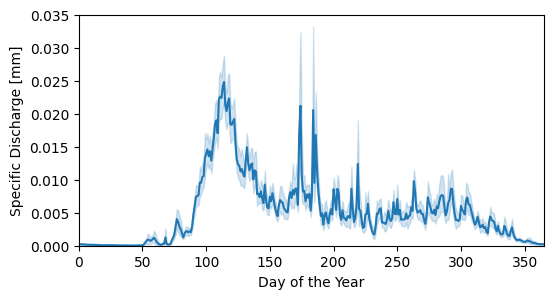

In [3]:
#General Streamflow plot
fig, ax = plt.subplots(1, 1,figsize = (6,3))
sns.lineplot(data = stream, x = stream.DateTime.dt.dayofyear, y = 'q_interval',
             ax = ax)
ax.set_xlim(0, 365)
ax.set_ylim(0, 0.035)
ax.set_ylabel('Specific Discharge [mm]')
ax.set_xlabel('Day of the Year')

In [4]:
#delineate years based on seasonal data
data = data.sort_values(['year', 'season'], ascending = [True, False]).reset_index(drop = True)
meanSnow = data[data.season == 'Snow']['Snow_in'].median()
meanPrecip = data.groupby(['year'])['South_PCP'].sum().median()

data['snowQuant'] = data[data.season == 'Snow']['Snow_in'].transform(
    lambda x: 'High' if x > meanSnow else 'Low')
data['snowQuant'] = data['snowQuant'].ffill()
data['precipQuant'] = data.groupby(['year'])['South_PCP'].transform(
    lambda x: 'High' if x.sum() > meanPrecip else 'Low')

#Remove low precip, high snow for consistency
data_frost = data[-((data.snowQuant == 'High') & (data.precipQuant == 'Low'))].reset_index(drop = True)
#Calculate expected frost quant
data_frost['frostQuant'] = ['High' if ((data_frost.snowQuant[i] == 'Low') & (data_frost.precipQuant[i] == 'Low')) else
                        'Med' if ((data_frost.snowQuant[i] == 'Low') & (data_frost.precipQuant[i] == 'High')) else
                        'Low' for i in range (0, len(data_frost.index))]

#Merge stream with precip for cumulative comparison
stream['Date'] = pd.to_datetime(stream.DateTime.dt.date)
stream_daily = stream.groupby('Date')['q_interval'].sum().reset_index()
stream_daily = pd.merge(stream_daily, precip[['DATE_datetime', 'South_PCP']], left_on = 'Date', right_on = 'DATE_datetime').drop(columns = 'DATE_datetime')
stream_daily.head()

#Streamflow regime by frost type (using high/low precip and snow delineations)
stream_daily['year'] = stream_daily.Date.dt.year
stream_daily = pd.merge(stream_daily, data_frost.groupby('year')[['snowQuant', 'precipQuant', 'frostQuant']].max(), on = 'year')

In [5]:
stream_daily.head()

,Date,q_interval,South_PCP,year,snowQuant,precipQuant,frostQuant
0,1969-01-01,0.00461,0.00,1969,High,High,Low
1,1969-01-02,0.00474,0.18,1969,High,High,Low
2,1969-01-03,0.00518,0.00,1969,High,High,Low
3,1969-01-04,0.00518,0.00,1969,High,High,Low
4,1969-01-05,0.00560,0.00,1969,High,High,Low


Text(0.5, 0, 'Day of the Year')

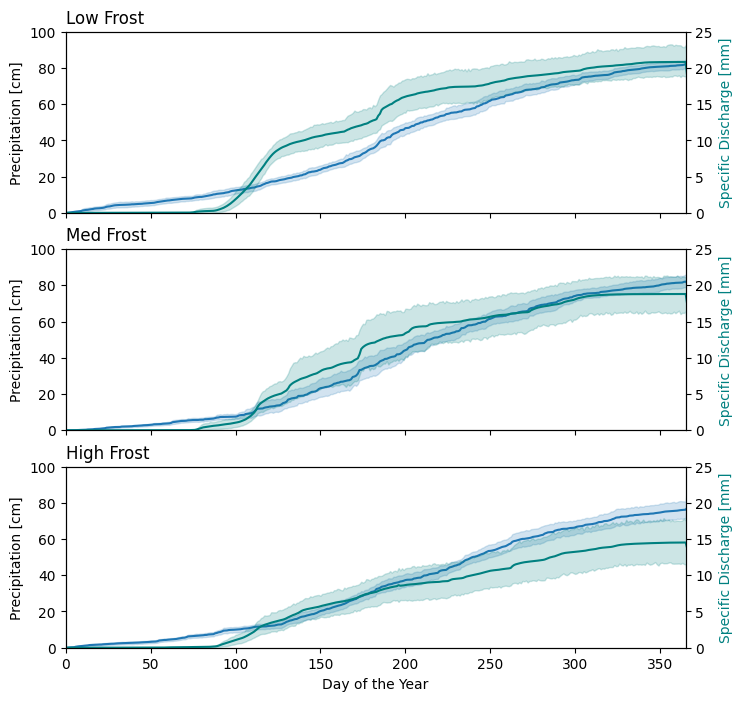

In [6]:
fig, [ax1, ax2, ax3] = plt.subplots(3, 1, figsize = (8, 8), 
                                    sharex = True, 
                                    sharey = True)
#Low Frost
sns.lineplot(x = stream_daily[stream_daily.frostQuant == 'Low'].Date.dt.dayofyear, y = stream_daily[stream_daily.frostQuant == 'Low'].groupby('year')['South_PCP'].cumsum(),
            ax = ax1)
ax11 = plt.twinx(ax1)
sns.lineplot(x = stream_daily[stream_daily.frostQuant == 'Low'].Date.dt.dayofyear, y = stream_daily[stream_daily.frostQuant == 'Low'].groupby('year')['q_interval'].cumsum(),
            ax = ax11, 
            color = 'teal')
ax1.set_title('Low Frost', loc = 'left')
ax1.set_xlim(0, 365)
ax1.set_ylim(0, 100)
ax11.set_ylim(0, 25)
ax1.set_ylabel('Precipitation [cm]')
ax11.set_ylabel('Specific Discharge [mm]', color = 'teal')
ax1.set_xlabel('Day of the Year')

#Med Frost
sns.lineplot(x = stream_daily[stream_daily.frostQuant == 'Med'].Date.dt.dayofyear, y = stream_daily[stream_daily.frostQuant == 'Med'].groupby('year')['South_PCP'].cumsum(),
            ax = ax2)
ax22 = plt.twinx(ax2)
sns.lineplot(x = stream_daily[stream_daily.frostQuant == 'Med'].Date.dt.dayofyear, y = stream_daily[stream_daily.frostQuant == 'Med'].groupby('year')['q_interval'].cumsum(),
            ax = ax22, 
            color = 'teal')
ax2.set_title('Med Frost', loc = 'left')
ax2.set_xlim(0, 365)
ax22.set_ylim(0, 25)
ax2.set_ylim(0, 100)
ax2.set_ylabel('Precipitation [cm]')
ax22.set_ylabel('Specific Discharge [mm]', color = 'teal')
ax2.set_xlabel('Day of the Year')

#High Frost
sns.lineplot(x = stream_daily[stream_daily.frostQuant == 'High'].Date.dt.dayofyear, y = stream_daily[stream_daily.frostQuant == 'High'].groupby('year')['South_PCP'].cumsum(),
            ax = ax3)
ax33 = plt.twinx(ax3)
sns.lineplot(x = stream_daily[stream_daily.frostQuant == 'High'].Date.dt.dayofyear, y = stream_daily[stream_daily.frostQuant == 'High'].groupby('year')['q_interval'].cumsum(),
            ax = ax33, 
            color = 'teal')
ax3.set_title('High Frost', loc = 'left')
ax3.set_xlim(0, 365)
ax3.set_ylim(0, 100)
ax33.set_ylim(0, 25)
ax3.set_ylabel('Precipitation [cm]')
ax33.set_ylabel('Specific Discharge [mm]', color = 'teal')
ax3.set_xlabel('Day of the Year')

In [7]:
upFrostAnnual['frostQuantMeas'] = pd.qcut(upFrostAnnual['courseMean'], 3, labels = ['Low', 'Med', 'High'])
stream_daily = pd.merge(stream_daily, upFrostAnnual, on = 'year')
stream_daily.head()

,Date,q_interval,South_PCP,year,snowQuant,precipQuant,frostQuant,S21,S22,S23,courseMean,frostQuantMeas
0,1969-01-01,0.00461,0.00,1969,High,High,Low,0.0,0.0,0.0,0.0,Low
1,1969-01-02,0.00474,0.18,1969,High,High,Low,0.0,0.0,0.0,0.0,Low
2,1969-01-03,0.00518,0.00,1969,High,High,Low,0.0,0.0,0.0,0.0,Low
3,1969-01-04,0.00518,0.00,1969,High,High,Low,0.0,0.0,0.0,0.0,Low
4,1969-01-05,0.00560,0.00,1969,High,High,Low,0.0,0.0,0.0,0.0,Low


In [ ]:
#Streamflow regime by soil frost (measured) plot
sns.relplot(data = stream_daily, x = stream_daily.Date.dt.dayofyear, y = 'q_interval',
            kind = 'line',
            row = 'frostQuantMeas', row_order = ['Low', 'Med', 'High'],
            height = 2, aspect = 3)
plt.xlim(0, 365)
plt.axvline(x = 96, ymin = 0, ymax = 3, color = 'silver')
plt.axvline(x = 183, ymin = 0, ymax = 3, color = 'silver')
plt.axvline(x = 275, ymin = 0, ymax = 3, color = 'silver')
plt.ylabel('Specific Discharge [mm]')
plt.xlabel('Day of the Year')
plt.savefig('./Figures/Paper Figures/annual-streamflow-regime.pdf', bbox_inches = 'tight')
plt.savefig('./Figures/Paper Figures/annual-streamflow-regime.png', bbox_inches = 'tight')

Text(0.5, 0, 'Day of the Year')

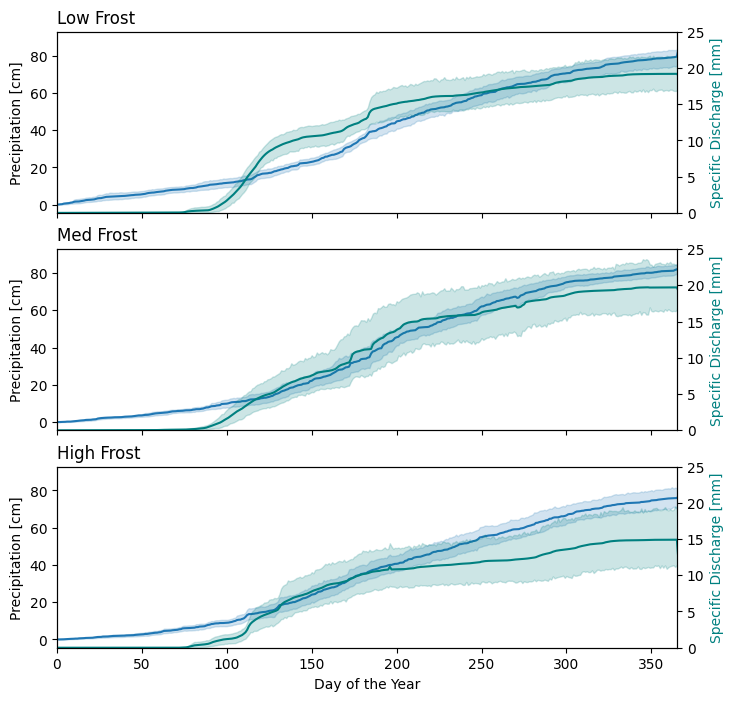

In [34]:
fig, [ax1, ax2, ax3] = plt.subplots(3, 1, figsize = (8, 8), 
                                    sharex = True, 
                                    sharey = True)
#Low Frost
sns.lineplot(x = stream_daily[stream_daily.frostQuantMeas == 'Low'].Date.dt.dayofyear, y = stream_daily[stream_daily.frostQuantMeas == 'Low'].groupby('year')['South_PCP'].cumsum(),
            ax = ax1)
ax11 = plt.twinx(ax1)
sns.lineplot(x = stream_daily[stream_daily.frostQuantMeas == 'Low'].Date.dt.dayofyear, y = stream_daily[stream_daily.frostQuantMeas == 'Low'].groupby('year')['q_interval'].cumsum(),
            ax = ax11, 
            color = 'teal')
ax1.set_title('Low Frost', loc = 'left')
ax1.set_xlim(0, 365)
#ax1.set_ylim(0, 100)
ax11.set_ylim(0, 25)
ax1.set_ylabel('Precipitation [cm]')
ax11.set_ylabel('Specific Discharge [mm]', color = 'teal')
ax1.set_xlabel('Day of the Year')

#Med Frost
sns.lineplot(x = stream_daily[stream_daily.frostQuantMeas == 'Med'].Date.dt.dayofyear, y = stream_daily[stream_daily.frostQuantMeas == 'Med'].groupby('year')['South_PCP'].cumsum(),
            ax = ax2)
ax22 = plt.twinx(ax2)
sns.lineplot(x = stream_daily[stream_daily.frostQuantMeas == 'Med'].Date.dt.dayofyear, y = stream_daily[stream_daily.frostQuantMeas == 'Med'].groupby('year')['q_interval'].cumsum(),
            ax = ax22, 
            color = 'teal')
ax2.set_title('Med Frost', loc = 'left')
ax2.set_xlim(0, 365)
#ax2.set_ylim(0, 100)
ax22.set_ylim(0, 25)
ax2.set_ylabel('Precipitation [cm]')
ax22.set_ylabel('Specific Discharge [mm]', color = 'teal')
ax2.set_xlabel('Day of the Year')

#High Frost
sns.lineplot(x = stream_daily[stream_daily.frostQuantMeas == 'High'].Date.dt.dayofyear, y = stream_daily[stream_daily.frostQuantMeas == 'High'].groupby('year')['South_PCP'].cumsum(),
            ax = ax3)
ax33 = plt.twinx(ax3)
sns.lineplot(x = stream_daily[stream_daily.frostQuantMeas == 'High'].Date.dt.dayofyear, y = stream_daily[stream_daily.frostQuantMeas == 'High'].groupby('year')['q_interval'].cumsum(),
            ax = ax33, 
            color = 'teal')
ax3.set_title('High Frost', loc = 'left')
ax3.set_xlim(0, 365)
# ax3.set_xlim(0, 100)
ax33.set_ylim(0, 25)
ax3.set_ylabel('Precipitation [cm]')
ax33.set_ylabel('Specific Discharge [mm]', color = 'teal')
ax3.set_xlabel('Day of the Year')

## Flashiness Analysis

Peaks over Threshold Analysis

In [35]:
from scipy.signal import find_peaks

In [36]:
stream_daily

,Date,q_interval,South_PCP,year,snowQuant,precipQuant,frostQuant,S21,S22,S23,courseMean,frostQuantMeas
0,1969-01-01,0.004610,0.00,1969,High,High,Low,0.0,0.0,0.0,0.00,Low
1,1969-01-02,0.004740,0.18,1969,High,High,Low,0.0,0.0,0.0,0.00,Low
2,1969-01-03,0.005180,0.00,1969,High,High,Low,0.0,0.0,0.0,0.00,Low
3,1969-01-04,0.005180,0.00,1969,High,High,Low,0.0,0.0,0.0,0.00,Low
4,1969-01-05,0.005600,0.00,1969,High,High,Low,0.0,0.0,0.0,0.00,Low
...,...,...,...,...,...,...,...,...,...,...,...,...
12022,2016-12-27,0.001043,0.00,2016,Low,High,Med,2.8,1.4,1.1,1.35,Low
12023,2016-12-28,0.000684,0.15,2016,Low,High,Med,2.8,1.4,1.1,1.35,Low
12024,2016-12-29,0.000736,0.09,2016,Low,High,Med,2.8,1.4,1.1,1.35,Low
12025,2016-12-30,0.000673,0.18,2016,Low,High,Med,2.8,1.4,1.1,1.35,Low


C:\Users\marie\AppData\Local\Temp\ipykernel_20180\1799691093.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 1, figsize = (6, 2))


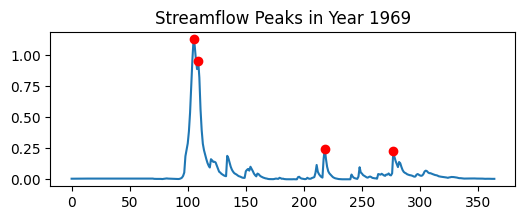

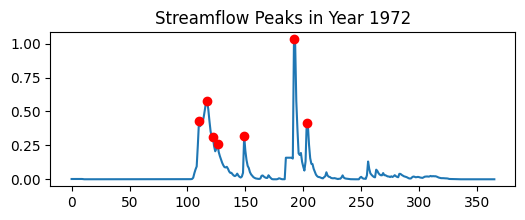

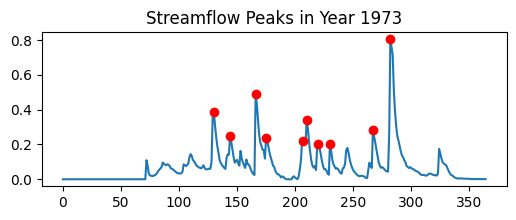

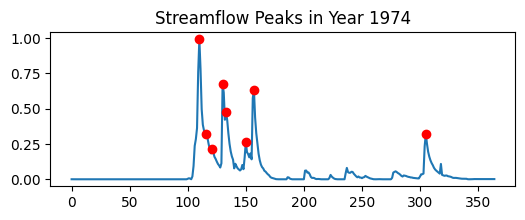

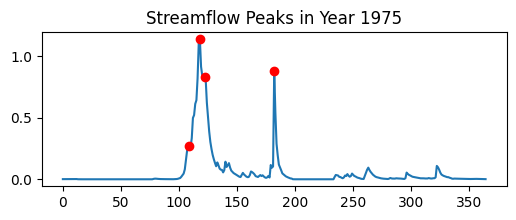

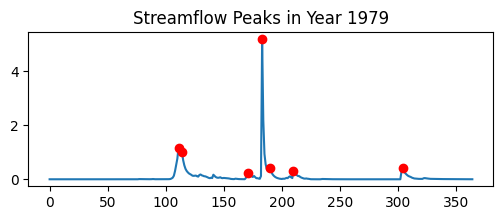

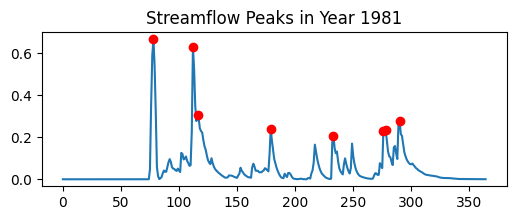

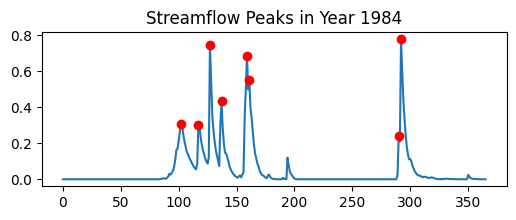

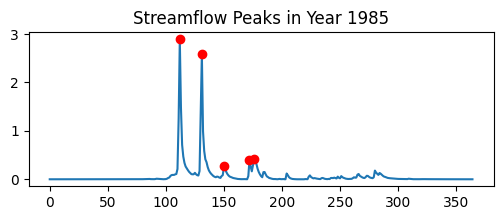

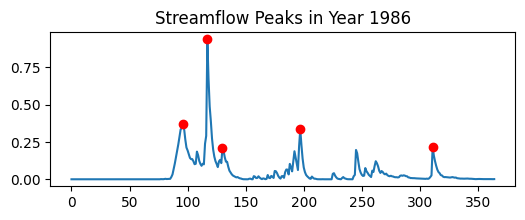

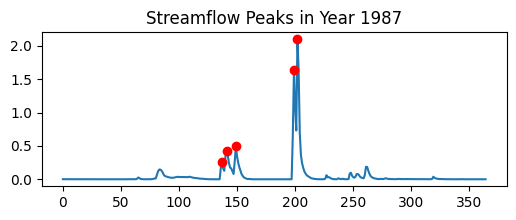

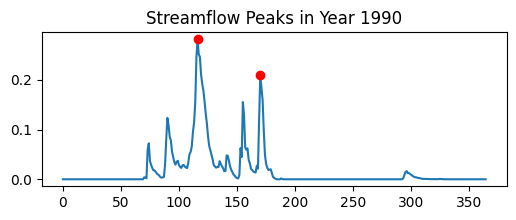

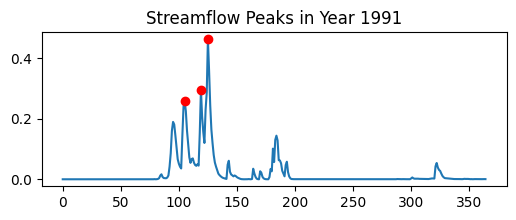

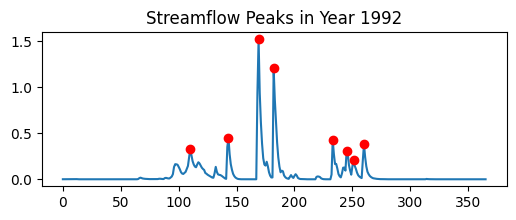

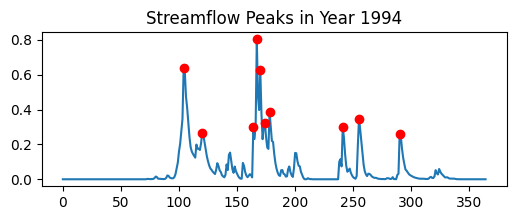

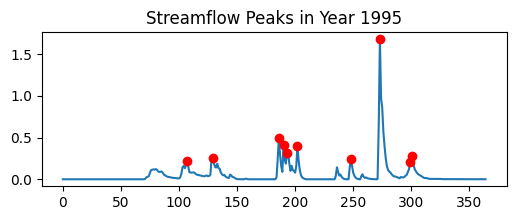

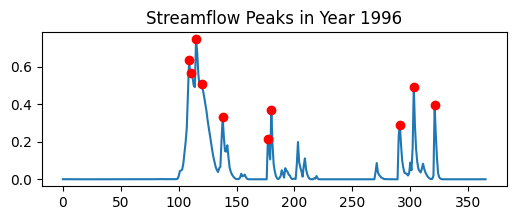

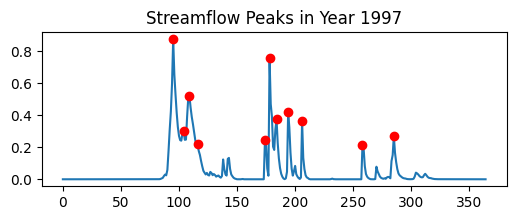

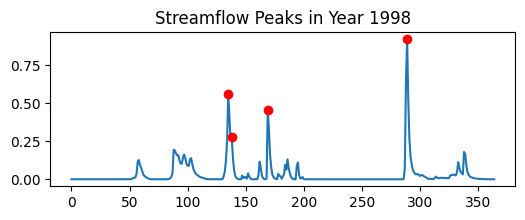

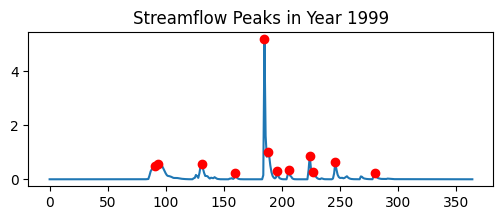

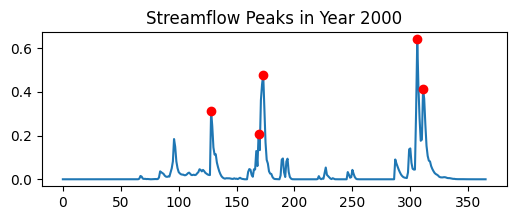

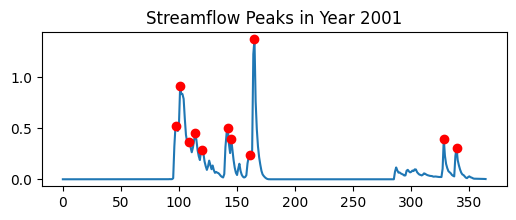

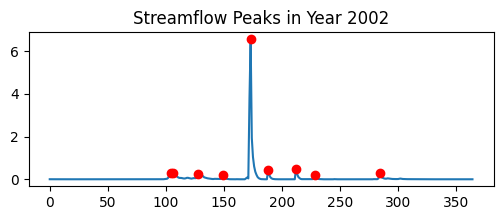

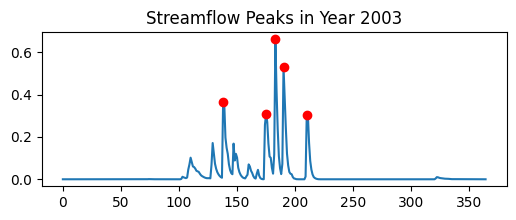

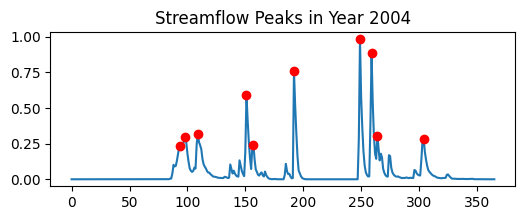

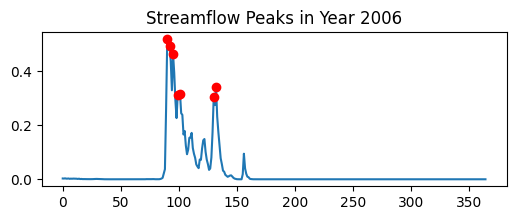

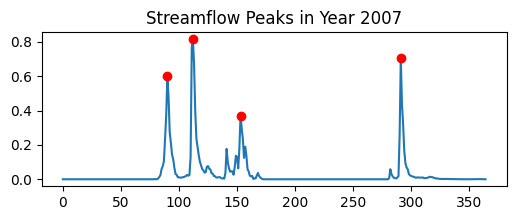

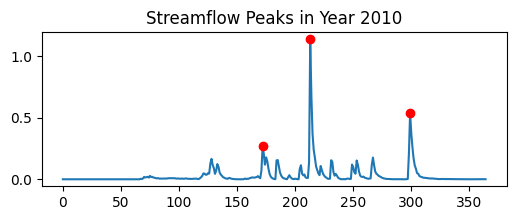

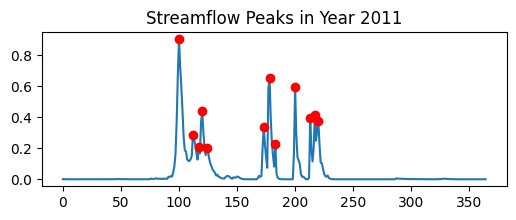

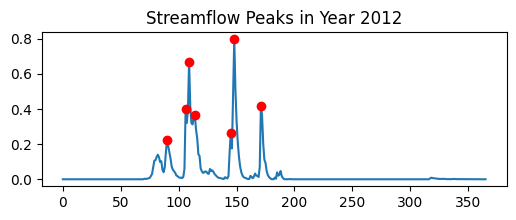

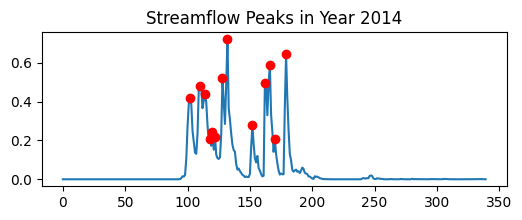

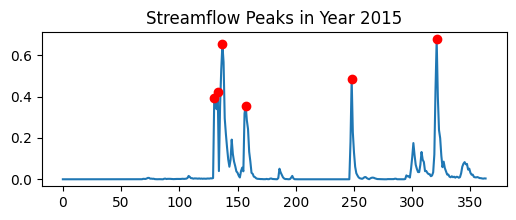

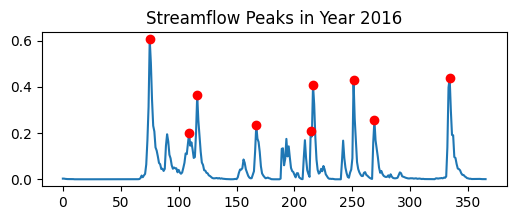

In [41]:
#For each year, find peaks and plot them for sense check
date = []
peak_height = []
snowQuant = []
precipQuant = []
frostQuant = []
frostQuantMeas = []
frostThickness = []

for y in set(stream_daily.year):
    temp = stream_daily[stream_daily.year == y].reset_index()
    peaks, _ = find_peaks(temp.q_interval, height = 0.2) #Threshold set to have same mean number of POT as Smith and Smith (2015)

    fig, ax = plt.subplots(1, 1, figsize = (6, 2))
    ax.plot(temp.q_interval)
    for peak in peaks:
        ax.plot(peak, temp.q_interval[peak], 'or')

        #save data
        date.append(temp.Date[peak])
        peak_height.append(temp.q_interval[peak])
        snowQuant.append(temp.snowQuant[peak])
        precipQuant.append(temp.precipQuant[peak])
        frostQuant.append(temp.frostQuant[peak])
        frostQuantMeas.append(temp.frostQuantMeas[peak])
        frostThickness.append(temp.courseMean[peak])
    
    ax.set_title('Streamflow Peaks in Year ' + str(y))


In [42]:
#Collate into dataframe
pot_analysis = pd.DataFrame({'date' : date,  
                             'peak' : peak_height, 
                             'snowQuant' : snowQuant, 
                             'precipQuant' : precipQuant, 
                             'frostQuant' : frostQuant, 
                             'frostQuantMeas' : frostQuantMeas, 
                             'frostThickness' : frostThickness})

# Rough seasonal delineation
pot_analysis['year'] = pot_analysis.date.dt.year
pot_analysis['DOY'] = pot_analysis.date.dt.dayofyear
pot_analysis['season'] = ['Melt' if ((doy > 122) & (doy < 183)) else 
                          'Growing' if ((doy > 182) & (doy < 275)) else
                          'Snow' for doy in pot_analysis.DOY]
pot_analysis

,date,peak,snowQuant,precipQuant,frostQuant,frostQuantMeas,frostThickness,year,DOY,season
0,1969-04-16,1.128113,High,High,Low,Low,0.000000,1969,106,Snow
1,1969-04-20,0.954711,High,High,Low,Low,0.000000,1969,110,Snow
2,1969-08-07,0.247503,High,High,Low,Low,0.000000,1969,219,Growing
3,1969-10-05,0.224363,High,High,Low,Low,0.000000,1969,278,Snow
4,1972-04-20,0.431704,High,High,Low,Med,6.583333,1972,111,Snow
...,...,...,...,...,...,...,...,...,...,...
237,2016-08-02,0.207660,Low,High,Med,Low,1.350000,2016,215,Growing
238,2016-08-04,0.408690,Low,High,Med,Low,1.350000,2016,217,Growing
239,2016-09-08,0.428710,Low,High,Med,Low,1.350000,2016,252,Growing
240,2016-09-26,0.255810,Low,High,Med,Low,1.350000,2016,270,Growing


In [43]:
#Annual summary
pot_annual = pot_analysis.groupby('year')[['peak', 'frostThickness']].mean()
pot_annual = pd.merge(pot_annual, pot_analysis.groupby('year')[['snowQuant', 'precipQuant', 'frostQuant', 'frostQuantMeas']].min(), on = 'year')
pot_annual = pd.merge(pot_annual, pot_analysis.groupby('year')['peak'].count(), on = 'year').reset_index()
pot_annual = pot_annual.rename(columns = {'peak_x':'mean_peak', 'peak_y':'POT'})
pot_annual.head()

,year,mean_peak,frostThickness,snowQuant,precipQuant,frostQuant,frostQuantMeas,POT
0,1969,0.638672,0.000000,High,High,Low,Low,4
1,1972,0.478316,6.583333,High,High,Low,Med,7
2,1973,0.341253,15.855072,Low,Low,High,High,10
3,1974,0.487956,16.050000,Low,Low,High,High,8
4,1975,0.781039,0.433333,High,High,Low,Low,4


Text(0.5, 0, 'Frost Thickness [cm]')

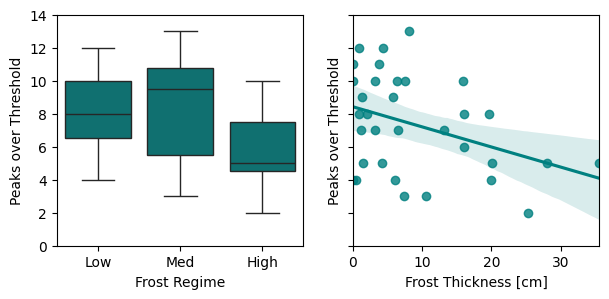

In [44]:
#Plot by frost regime
fig, [ax1, ax2] = plt.subplots(1, 2, figsize = (7, 3), 
                               sharey = True)
sns.boxplot(data = pot_annual, x = 'frostQuantMeas', y = 'POT', color = 'teal', ax = ax1)
sns.regplot(data = pot_annual, x = 'frostThickness', y = 'POT', color = 'teal', ax = ax2)
ax1.set_ylim(0, 14)
ax2.set_xlim(min(pot_analysis.frostThickness), max(pot_analysis.frostThickness))
ax1.set_ylabel('Peaks over Threshold')
ax2.set_ylabel('Peaks over Threshold')
ax1.set_xlabel('Frost Regime')
ax2.set_xlabel('Frost Thickness [cm]')

In [45]:
#Seasonal summary
pot_seasonal = pot_analysis.groupby(['year', 'season'])[['peak', 'frostThickness']].mean()
pot_seasonal = pd.merge(pot_seasonal, pot_analysis.groupby(['year', 'season'])[['snowQuant', 'precipQuant', 'frostQuant', 'frostQuantMeas']].min(), on = ['year', 'season'])
pot_seasonal = pd.merge(pot_seasonal, pot_analysis.groupby(['year', 'season'])['peak'].count(), on = ['year', 'season']).reset_index()
pot_seasonal = pot_seasonal.rename(columns = {'peak_x':'mean_peak', 'peak_y':'POT'})
pot_seasonal = pot_seasonal.sort_values(['year', 'season'], ascending = [True, False]).reset_index(drop = True)
pot_seasonal.head()

,year,season,mean_peak,frostThickness,snowQuant,precipQuant,frostQuant,frostQuantMeas,POT
0,1969,Snow,0.769062,0.000000,High,High,Low,Low,3
1,1969,Growing,0.247503,0.000000,High,High,Low,Low,1
2,1972,Snow,0.503006,6.583333,High,High,Low,Med,2
3,1972,Melt,0.298104,6.583333,High,High,Low,Med,3
4,1972,Growing,0.723945,6.583333,High,High,Low,Med,2


C:\Users\marie\AppData\Local\Temp\ipykernel_20180\2401567876.py:20: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:Black'` for the same effect.

  sns.boxplot(data = stream_daily, x = 'frostQuantMeas', y = 'q_interval', hue = 'season',


Text(0.5, 0, 'Frost Quantile, Upland')

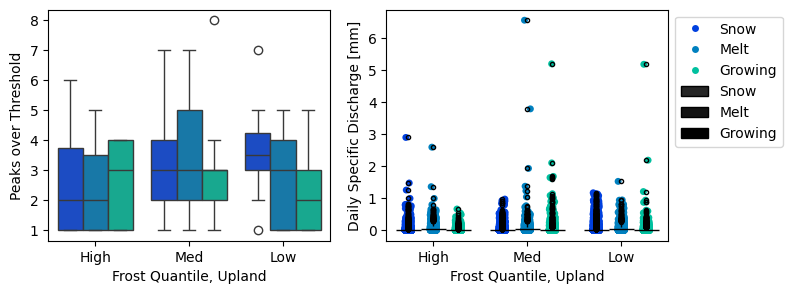

In [69]:
fig, [ax, ax2] = plt.subplots(1, 2, figsize = (8, 3))

sns.boxplot(data = pot_seasonal, x = 'frostQuantMeas', y = 'POT', hue = 'season', 
              dodge = True, 
              palette = 'winter',
              order = ['High', 'Med', 'Low'],
              legend = None,
              ax = ax)

stream_daily['DOY'] = stream_daily.Date.dt.dayofyear
stream_daily['season'] = ['Melt' if ((doy > 122) & (doy < 183)) else 
                          'Growing' if ((doy > 182) & (doy < 275)) else
                          'Snow' for doy in stream_daily.DOY]

sns.stripplot(data = stream_daily, x = 'frostQuantMeas', y = 'q_interval', hue = 'season', 
              dodge = True, 
              palette = 'winter',
              order = ['High', 'Med', 'Low'],
              ax = ax2)
sns.boxplot(data = stream_daily, x = 'frostQuantMeas', y = 'q_interval', hue = 'season',
              dodge = True, 
              color = 'Black',
              order = ['High', 'Med', 'Low'],
              flierprops={"marker": "."},
              showbox = False, showcaps = False, 
              ax = ax2, zorder = 4)
ax2.legend(bbox_to_anchor = (1, 1))
ax.set_ylabel('Peaks over Threshold')
ax.set_xlabel('Frost Quantile, Upland')
ax2.set_ylabel('Daily Specific Discharge [mm]')
ax2.set_xlabel('Frost Quantile, Upland')

